# Imports

In [10]:
# !pip install --upgrade pip
# !pip install pandas
# !pip install re
# !pip install string
# !pip install seaborn
# !pip install matplotlib
# !pip install textblob
# !pip install nltk
# !pip install tqdm
# !pip install spacy
# !pip install tensorflow_hub
# !pip install sklearn

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import pickle
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn import metrics
from IPython.display import clear_output

path=''

import sys
sys.path.append(path)
# !pip install sentencepiece 
import tokenization

# Code

In [2]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

def decontract(raw_html):
    for word in raw_html.split():
        if word.lower() in contractions:
            raw_html = raw_html.replace(word, contractions[word.lower()])
    return raw_html

In [3]:
%%time
tf.keras.backend.clear_session()
max_seq_length = mymaxlen = 170
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

CPU times: user 9.22 s, sys: 1.11 s, total: 10.3 s
Wall time: 10.2 s


In [20]:
auc_list=[]
acc_list = []
class terminate_at(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        auc_ = logs['val_auc_score']
        auc_list.append(auc_)
        acc_list.append(logs['val_accuracy'])
        if auc_>=0.99:
            self.model.stop_training = True
terminate_at = terminate_at()

def auc_score(y_true, y_pred):
    return tf.py_function(roc_auc_score,(y_true,y_pred),tf.double) 

checkpoint = ModelCheckpoint(filepath=path+"bert_model2.hdf5", monitor='val_auc_score', \
                             verbose=1, save_best_only=True, mode='max')


def fun(X):
    X_t = []
    X_m = []
    X_s = []
    mymaxlen = 170
    fornulls = []
    for i in range(mymaxlen-2):
            fornulls.append('[PAD]')

    for i in range(len(X)):
        if len(X)==1:
            tokens = tokenizer.tokenize(X[0])
        else:
            tokens = tokenizer.tokenize(X.values[i])
        
        if len(tokens)>=(mymaxlen-2):
            tokens = tokens[0:(mymaxlen-2)]
            tokens = ['[CLS]', *tokens, '[SEP]']
            only_token = len(tokens)  
        else:
            tokens = ['[CLS]', *tokens, '[SEP]'] 
            only_token = len(tokens) 
            gap = max_seq_length-only_token
            for j in range(gap):
                tokens.append('[PAD]')

        if np.asarray(tokenizer.convert_tokens_to_ids(tokens)) is not None:
            X_t.append(np.asarray(tokenizer.convert_tokens_to_ids(tokens)))
        else :
            X_t.append(np.asarray(tokenizer.convert_tokens_to_ids(['[CLS]', *fornulls, '[SEP]'])))

        if (np.asarray([1]*len(tokens)+[0]*(max_seq_length-len(tokens)))) is not None:
            X_m.append(np.asarray([1]*(only_token)+[0]*(max_seq_length-only_token)))
        else :
            X_m.append(np.asarray([1]*len(fornulls)+[0]*(max_seq_length-len(fornulls))))
        X_s.append(np.asarray([0]*max_seq_length))

    X_t = np.asarray(X_t)
    X_m = np.asarray(X_m)
    X_s = np.asarray(X_s)
    return X_t, X_m, X_s

In [5]:
df = pd.read_csv('Train.csv')

X_train, X_test, y_train, y_test = \
    train_test_split(df['text'], df['sentiment'], stratify=df['sentiment'], test_size=0.20, random_state = 33)

In [6]:
%%time
X_train_tokens, X_train_mask, X_train_segment = fun(X_train)
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

CPU times: user 1min 37s, sys: 1min 25s, total: 3min 2s
Wall time: 3min 2s


In [7]:
%%time
X_test_tokens, X_test_mask, X_test_segment = fun(X_test)
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

CPU times: user 23.7 s, sys: 21.6 s, total: 45.3 s
Wall time: 45.1 s


In [8]:
# X_train_pooled_output = pickle.load(open('final_train_pool_output.pkl', 'rb'))
# X_test_pooled_output = pickle.load(open('final_test_pool_output.pkl', 'rb'))
# y_train, y_test = pickle.load(open('ytrain_ytest.pkl', 'rb'))

y_train_ = tf.keras.utils.to_categorical(y_train, 2)
y_test_ = tf.keras.utils.to_categorical(y_test, 2)

In [14]:
inputs = tf.keras.Input(shape=(768,))
layer = Dense(40, activation=tf.nn.relu)(inputs)
layer = Dense(100, activation=tf.nn.relu)(layer)
layer = Dense(150, activation=tf.nn.relu)(layer)
layer = Dense(30, activation=tf.nn.relu)(layer)
outputs = Dense(2, activation=tf.nn.softmax)(layer)


model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', auc_score])
model.fit(X_train_pooled_output, y_train_, validation_data=(X_test_pooled_output, y_test_),\
          epochs=200, verbose=1,  callbacks=[checkpoint, terminate_at], batch_size = 400)

Train on 7600 samples, validate on 1900 samples
Epoch 1/200
4400/7600 [================>.............] - ETA: 0s - loss: 0.5229 - accuracy: 0.7632 - auc_score: 0.6339
Epoch 00001: val_auc_score improved from -inf to 0.79120, saving model to bert_model2.hdf5
7600/7600 [==============================] - 1s 94us/sample - loss: 0.5035 - accuracy: 0.7787 - auc_score: 0.6859 - val_loss: 0.4615 - val_accuracy: 0.8000 - val_auc_score: 0.7912
Epoch 2/200
7200/7600 [===========================>..] - ETA: 0s - loss: 0.4345 - accuracy: 0.8035 - auc_score: 0.7898
Epoch 00002: val_auc_score improved from 0.79120 to 0.85499, saving model to bert_model2.hdf5
7600/7600 [==============================] - 0s 26us/sample - loss: 0.4300 - accuracy: 0.8050 - auc_score: 0.7936 - val_loss: 0.3724 - val_accuracy: 0.8358 - val_auc_score: 0.8550
Epoch 3/200
4000/7600 [==============>...............] - ETA: 0s - loss: 0.3701 - accuracy: 0.8435 - auc_score: 0.8576
Epoch 00003: val_auc_score improved from 0.85499 t

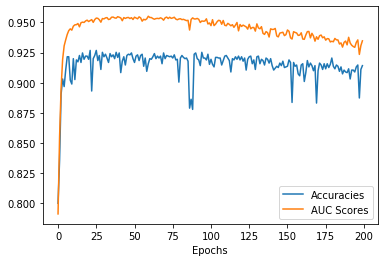

In [15]:
from matplotlib import pyplot as plt
plt.plot(acc_list)
plt.plot(auc_list)
plt.legend(['Accuracies', 'AUC Scores'])
plt.xlabel('Epochs')
plt.show()

# Making Predictions

In [17]:
%%time
import re, string
df = pd.read_csv('Test.csv')
def simple_preprocessing_function(text):
    text = re.sub('@\S*\s','',text+str(' '))      # Removing @VirginAmerica and likes of that
    text = re.sub('http:\S*\s','',text+str(' '))  # Remove hyperlinks
    text = decontract(text)                       # Decontractions
    text = re.sub("[^-9A-Za-z ]", " " , text)     # Remove punctuations and special charaters
    text = re.sub(' +', ' ', text)                # Remove extra spaces
    text = "".join([i.lower() for i in text if i not in string.punctuation])  # To lower case
    return text

prep_text = []
for i in df.text:
    prep_text.append(simple_preprocessing_function(i))

df['text'] = prep_text


tf.keras.backend.clear_session()
max_seq_length = mymaxlen = 170
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


Xn_test_tokens, Xn_test_mask, Xn_test_segment = fun(df['text'])

CPU times: user 9 s, sys: 607 ms, total: 9.6 s
Wall time: 9.46 s


In [21]:
%%time
cl=bert_model.predict([Xn_test_tokens, Xn_test_mask, Xn_test_segment])

nnmodel = tf.keras.models.load_model("bert_model2.hdf5", compile=False)
nnmodel.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', auc_score])
cl = nnmodel.predict(cl).argmax(axis=-1) # 0 bad ,1 Good

CPU times: user 23 s, sys: 21.4 s, total: 44.4 s
Wall time: 44.1 s


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


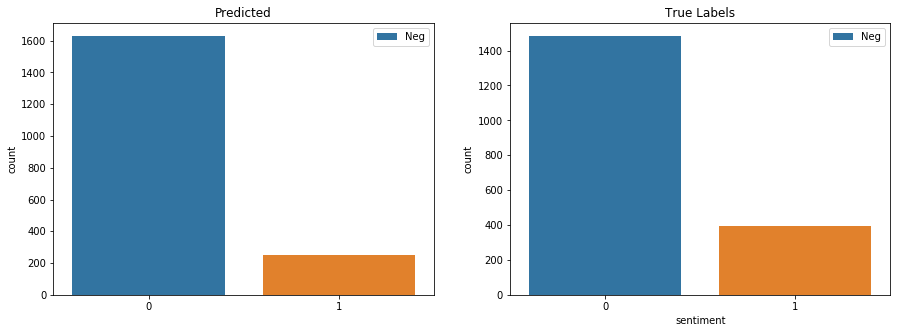

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(cl)
plt.legend(['Neg', 'Pos'])
plt.title('Predicted')

plt.subplot(1,2,2)
sns.countplot(df.sentiment)
plt.legend(['Neg', 'Pos'])
plt.title('True Labels')
plt.show()

In [1]:
print("Accuracy:",round(metrics.accuracy_score(df.sentiment, cl), 2) \
,"Precision:",round(metrics.precision_score(df.sentiment, cl), 2) \
,"Recall:",round(metrics.recall_score(df.sentiment, cl), 2))

# Accuracy: 0.89 Precision: 0.9 Recall: 0.57

# Single Review Classification

In [2]:
import re, string

In [39]:
%%time
mytext = 'This is the worst product ever.'

def simple_preprocessing_function(text):
    text = re.sub('@\S*\s','',text+str(' '))      # Removing @VirginAmerica and likes of that
    text = re.sub('http:\S*\s','',text+str(' '))  # Remove hyperlinks
    text = decontract(text)                       # Decontractions
    text = re.sub("[^-9A-Za-z ]", " " , text)     # Remove punctuations and special charaters
    text = re.sub(' +', ' ', text)                # Remove extra spaces
    text = "".join([i.lower() for i in text if i not in string.punctuation])  # To lower case
    return text

prep_text = []
prep_text.append(simple_preprocessing_function(mytext))



tf.keras.backend.clear_session()
max_seq_length = mymaxlen = 170
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Xn_test_tokens, Xn_test_mask, Xn_test_segment = fun(prep_text)
cl=bert_model.predict([Xn_test_tokens, Xn_test_mask, Xn_test_segment])

nnmodel = tf.keras.models.load_model("bert_model2.hdf5", compile=False)
nnmodel.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', auc_score])
                                                # 0 bad ,1 Good
clear_output()

CPU times: user 9.74 s, sys: 690 ms, total: 10.4 s
Wall time: 10.3 s


In [40]:
print(round(nnmodel.predict(cl)[0][0], 4), '% Negetive. ', round(nnmodel.predict(cl)[0][1], 4), '% Positive.')
if nnmodel.predict(cl).argmax(axis=-1) == 0:
    print('Negetive Review.')
else:
    print('Positive Review.')
    
# 0.9953 % Negetive.  0.0047 % Positive.
# Negetive Review.

0.9953 % Negetive.  0.0047 % Positive.
Negetive Review.
